# Segmentación del baso en tomografía computada abdominal en Amazon Sagemaker

El objetivo  es entrenar un modelo que segmente el área de imagen perteneciente al baso en un corte de tomografía computada de abdomen. 
Para eso, utilizaremos un dataset de 41 tomografías donde se ha delimitado manualmente el área del baso.
Dataset: https://arxiv.org/abs/1902.09063

El entrenamiento va a ser realizado con Amazon Sagemaker Semantic Segmentation 


In [1]:
%%time
import sagemaker
from sagemaker import get_execution_role
import boto3

role = get_execution_role()
print(role)
sess = sagemaker.Session()

region = boto3.Session().region_name


arn:aws:iam::563487891580:role/service-role/AmazonSageMaker-ExecutionRole-20190817T122869
CPU times: user 1.31 s, sys: 470 ms, total: 1.78 s
Wall time: 9.58 s


Defino el Bucket S3 desde el cual saco las imagenes


In [2]:
#bucket = sess.default_bucket()  
bucket = 'sagemaker-spleen-training'  
prefix = '2D_train'
print(bucket)

sagemaker-spleen-training


# Preparo los datos del dataset para el container

In [3]:
DATA_PATH = 'dataset/spleen_training'
FRAME_PATH = DATA_PATH+'/images2D/'
MASK_PATH = DATA_PATH+'/labels2D/'

## Defino funcion de dataprep 
Reparte las imagenes entre train y validation y las deja listas en los directorios para subir a S3

In [4]:
%%time
import os
import random
import re
from PIL import Image
import PIL.ImageOps 

def dataprep():
    
    # Create folders to hold images and masks
    folders = ['train', 'train_annotation', 'validation', 'validation_annotation', 'test', 'test_annotation']
    for folder in folders:
        os.makedirs(DATA_PATH + "/" + folder)

    # Get all frames and masks, sort them, shuffle them to generate data sets.
    all_frames = os.listdir(FRAME_PATH)
    all_masks = os.listdir(MASK_PATH)
    all_frames.sort(key=lambda var:[int(x) if x.isdigit() else x 
                                    for x in re.findall(r'[^0-9]|[0-9]+', var)])
    all_masks.sort(key=lambda var:[int(x) if x.isdigit() else x 
                                   for x in re.findall(r'[^0-9]|[0-9]+', var)])
    random.seed(230)
    random.shuffle(all_frames)

    # Generate train, val, and test sets for frames
    train_split = int(0.7*len(all_frames))
    val_split = int(0.9 * len(all_frames))
    train_frames = all_frames[:train_split]
    val_frames = all_frames[train_split:val_split]
    test_frames = all_frames[val_split:]

    # Generate corresponding mask lists for masks
    train_masks = [f for f in all_masks if f in train_frames]
    val_masks = [f for f in all_masks if f in val_frames]
    test_masks = [f for f in all_masks if f in test_frames]

    #Add train, val, test frames and masks to relevant folders
    def add_frames(dir_name, image):
        img = Image.open(FRAME_PATH+image)
        img.save(DATA_PATH+'/{}'.format(dir_name)+'/'+image)

    def add_masks(dir_name, image):
        filename = os.path.splitext(os.path.basename(MASK_PATH+image))[0]
        newname = DATA_PATH+"/"+dir_name+'/'+filename+'.png'
        im = Image.open(MASK_PATH+image)
        imP = im.convert('RGB').convert('P', palette=Image.ADAPTIVE, colors=2)
        imP.putpalette([
            0, 255, 0, # verde para la mascara
            255, 255, 255, # blanco para el fondo 
        ])
        imP.save(newname)
        
    frame_folders = [(train_frames, 'train'), (val_frames, 'validation'), 
                     (test_frames, 'test')]
    mask_folders = [(train_masks, 'train_annotation'), (val_masks, 'validation_annotation'), 
                    (test_masks, 'test_annotation')]

    # Add frames
    for folder in frame_folders:
        array = folder[0]
        name = [folder[1]] * len(array)
        list(map(add_frames, name, array))

    # Add masks
    for folder in mask_folders:
        array = folder[0]
        name = [folder[1]] * len(array)
        list(map(add_masks, name, array))

    return


CPU times: user 9.12 ms, sys: 220 µs, total: 9.34 ms
Wall time: 345 ms


Traigo la imagen del Amazon SageMaker Semantic Segmentaion docker 

## Defino funcion de dataupload a S3

In [5]:
train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

In [6]:
%%time
def dataupload():   
    # upload the appropraite directory up to s3 respectively for all directories.
    sess.upload_data(path=DATA_PATH+'/train', bucket=bucket, key_prefix=train_channel)
    sess.upload_data(path=DATA_PATH+'/validation', bucket=bucket, key_prefix=validation_channel)
    sess.upload_data(path=DATA_PATH+'/train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
    sess.upload_data(path=DATA_PATH+'/validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)
    # sess.upload_data(path='train_label_map.json', bucket=bucket, key_prefix=label_map_channel)
    return

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [7]:
def upload_to_s3(bucket, channel, filename):
    fobj=open(filename, 'rb')
    key = prefix+'/'+channel
    url = 's3://{}/{}/{}'.format(bucket, key, filename)
    print('Writing to {}'.format(url))
    write_to_s3(fobj, bucket, key)

In [8]:
def borrotodo():
    
    return

## Invoco dataprep y dataupload o no dependiendo si hace falta

In [9]:
# Borro todo
borrotodo()

In [10]:
%%time
dataprep()

CPU times: user 22.7 s, sys: 949 ms, total: 23.6 s
Wall time: 24 s


In [11]:
%%time
dataupload()

CPU times: user 9.64 s, sys: 476 ms, total: 10.1 s
Wall time: 2min 5s


In [12]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print(s3_output_location)

s3://sagemaker-spleen-training/2D_train/output


## Entrenamiento

In [13]:
from sagemaker.amazon.amazon_estimator import get_image_uri
training_image = get_image_uri(sess.boto_region_name, 'semantic-segmentation', repo_version="latest")
print (training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:latest


In [14]:
# Create the sagemaker estimator object.
ss_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count = 1, 
                                         train_instance_type = 'ml.p3.16xlarge',
#                                         train_instance_type = 'local_gpu',
                                         train_volume_size = 200,
                                         train_max_run = 360000,
                                         output_path = s3_output_location,
                                         base_job_name = 'spleen-segmentation',
                                         sagemaker_session = sess)

In [15]:
# Setup hyperparameters 
ss_model.set_hyperparameters(backbone='resnet-101', # This is the encoder. Other option is resnet-50
                             algorithm='psp', # This is the decoder.  options:  'psp' , 'deeplab' , 'fcn'                            
                             use_pretrained_model='True', # Use the pre-trained model.
                             crop_size=512, # Size of image random crop.                             
                             num_classes=2, # Spleen or nor spleen (hotdog or not hotdog!). This is a mandatory parameter.
                             epochs=30, # Number of epochs to run.
                             learning_rate=0.0001,                             
                             optimizer='adam', # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
                             lr_scheduler='poly', # Other options include 'cosine' and 'step'.                           
                             mini_batch_size=16, # Setup some mini batch size.
                             validation_mini_batch_size=16,
                             early_stopping=True, # Turn on early stopping. If OFF, other early stopping parameters are ignored.
                             early_stopping_patience=4, # Tolerate these many epochs if the mIoU doens't increase.
                             early_stopping_min_epochs=10, # No matter what, run these many number of epochs.                             
                             num_training_samples=735)    # This is a mandatory parameter, 735 in this case.

In [16]:
# Create full bucket names
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

distribution = 'FullyReplicated'
# Create sagemaker s3_input objects
train_data = sagemaker.session.s3_input(s3_train_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')

validation_data = sagemaker.session.s3_input(s3_validation_data, distribution=distribution, 
                                        content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')

validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution=distribution, 
                                        content_type='image/png', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 
                 'validation': validation_data,
                 'train_annotation': train_annotation, 
                 'validation_annotation':validation_annotation}

In [17]:
%%time
ss_model.fit(inputs=data_channels, logs=True)

2019-12-07 12:42:38 Starting - Starting the training job...
2019-12-07 12:42:39 Starting - Launching requested ML instances.........
2019-12-07 12:44:13 Starting - Preparing the instances for training......
2019-12-07 12:45:15 Downloading - Downloading input data...
2019-12-07 12:45:58 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[12/07/2019 12:46:02 INFO 139913182172992] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'gamma2': u'0.9', u'gamma1': u'0.9', u'early_stopping_min_epochs': u'5', u'epochs': u'10', u'_workers': u'16', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0001', u'crop_size': u'240', u'use_pretrained_model': u'True', u'_aux_weight': u'0.5', u'_hybrid': u'False', u'_augmentation_type': u'default', u'lr_scheduler': u'poly', u'early_stopping_patience': u'4', u'momentum': u'0.9', u'optimizer': u'sgd', u'early_stopping_tolerance': u'0.0', u'

# Hosting del modelo para inferencia
Preparo endpoint

In [18]:
%%time
ss_predictor = ss_model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge')

---------------------------------------------------------------------------------------------------!CPU times: user 499 ms, sys: 25.2 ms, total: 524 ms
Wall time: 8min 20s


## Inferencia
Armo loop para inferir la mascara de todas las que no se

(512, 512)
spleen_1.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_1.png


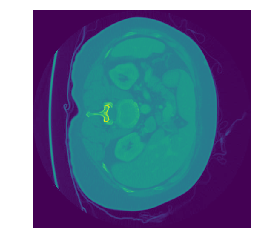

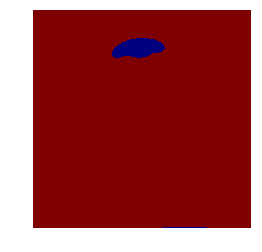

(512, 512)
spleen_23.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_23.png


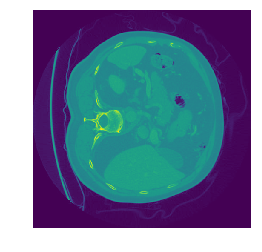

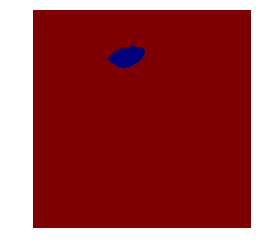

(512, 512)
spleen_39.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_39.png


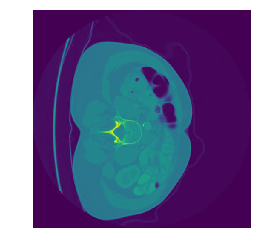

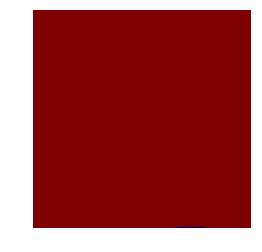

(512, 512)
spleen_50.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_50.png


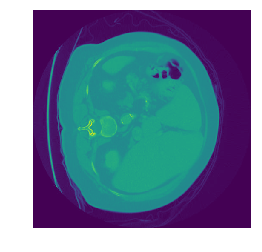

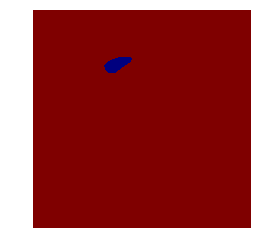

(512, 512)
spleen_54.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_54.png


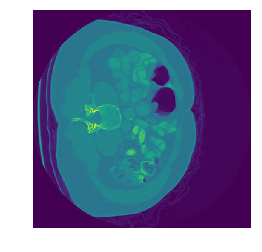

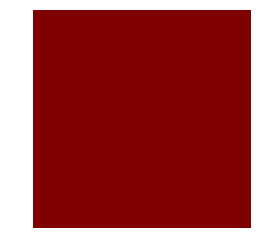

(512, 512)
spleen_42.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_42.png


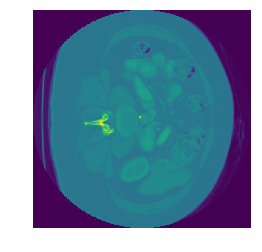

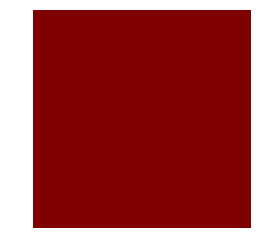

(512, 512)
spleen_48.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_48.png


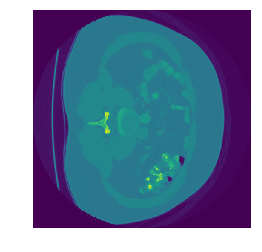

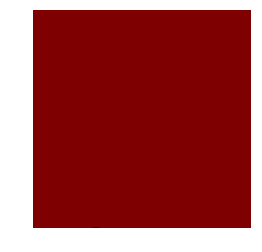

(512, 512)
spleen_30.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_30.png


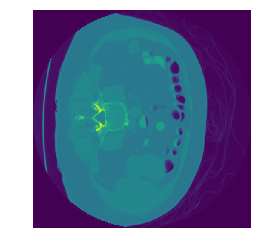

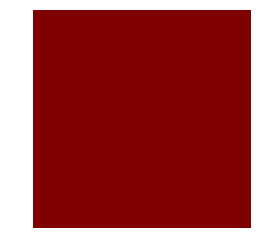

(512, 512)
spleen_7.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_7.png


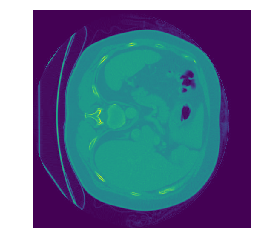

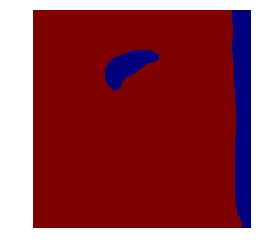

(512, 512)
spleen_15.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_15.png


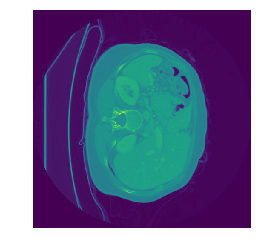

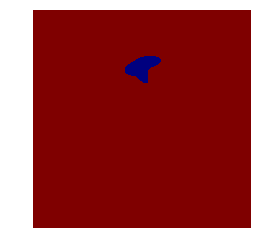

(512, 512)
spleen_57.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_57.png


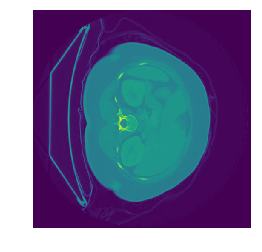

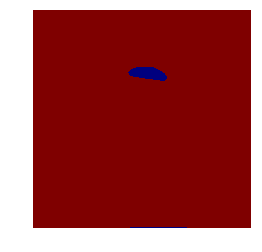

(512, 512)
spleen_51.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_51.png


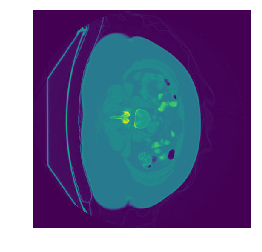

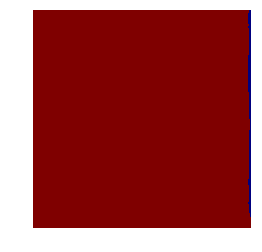

(512, 512)
spleen_37.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_37.png


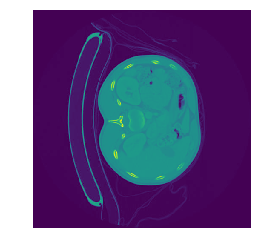

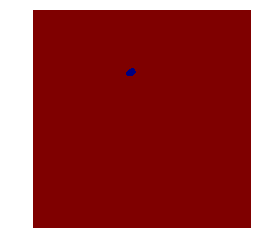

(512, 512)
spleen_58.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_58.png


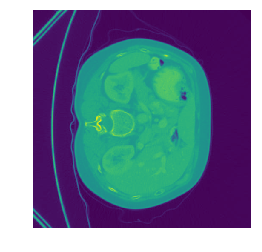

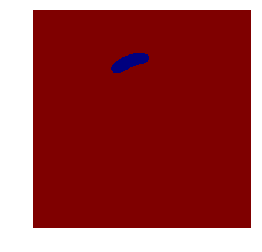

(512, 512)
spleen_11.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_11.png


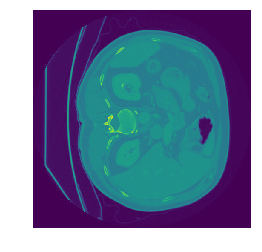

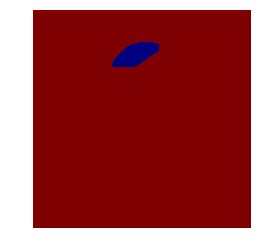

(512, 512)
spleen_43.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_43.png


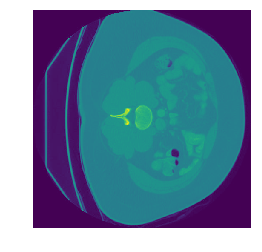

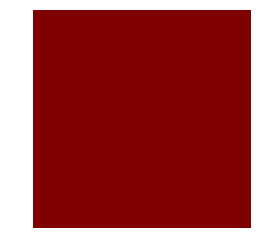

(512, 512)
spleen_34.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_34.png


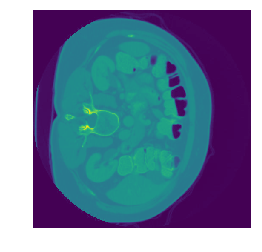

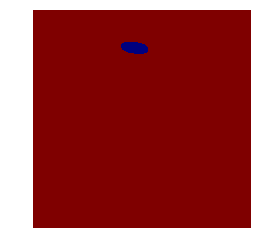

(512, 512)
spleen_55.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_55.png


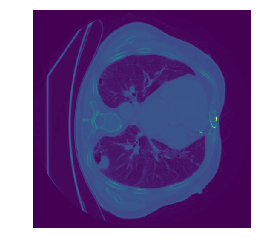

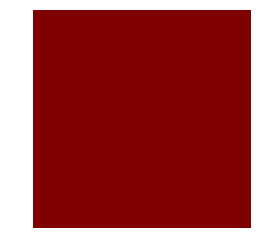

(512, 512)
spleen_36.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_36.png


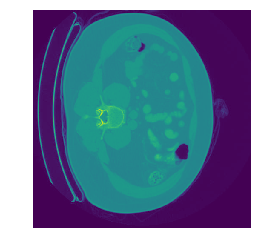

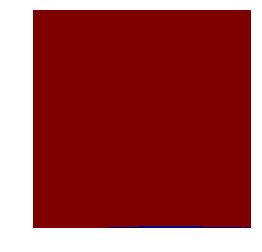

(512, 512)
spleen_35.png, dataset/spleen_training/unlabeled_predicted_masks/spleen_35.png


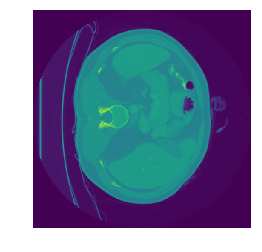

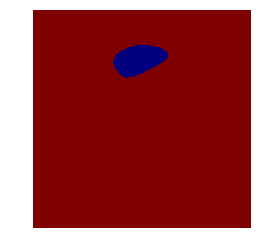

In [24]:
import matplotlib.pyplot as plt
import PIL
import os
import io
import numpy as np

unlabeled_path = DATA_PATH + "/unlabeled_images2D/"
unlabeled_predicted_masks_path = DATA_PATH + "/unlabeled_predicted_masks/"

for filename in os.listdir(unlabeled_path):
    im = PIL.Image.open(unlabeled_path + filename)
    with open(unlabeled_path + filename, 'rb') as image:
        # leo el archivo a inferir
        img = image.read()
        img = bytearray(img)
        
        # lo mando al endpoint para que me devuelva la mascara
        ss_predictor.content_type = 'image/jpeg'
        ss_predictor.accept = 'image/png'
        return_img = ss_predictor.predict(img)
        num_classes = 2
        
        # Abro la mascara
        mask_image = Image.open(io.BytesIO(return_img))
        mask = np.array(mask_image)
        print(mask.shape)
        
        # Guardo la mascara en el filesystem
        filename_out = os.path.splitext(os.path.basename(filename))[0]+".png"
        complete_filename_out = unlabeled_predicted_masks_path+filename_out
        print("{}, {}".format(filename_out, complete_filename_out))
        mask_image.save(complete_filename_out, "PNG")
        
        # Muestro  archivo original con su mascara
        plt.imshow(im)
        plt.axis('off')
        plt.show()
        plt.imshow(mask, vmin=0, vmax=num_classes-1, cmap='jet')
        plt.axis('off')
        plt.show()
#        overlay = im
#        new_image = Image.new("RGBA", img.size, "WHITE")
#        overlay.paste(mask, (0, 0), mask)
#        plt.imshow(overlay)
#        plt.axis('off')
#        plt.show()



In [20]:
# Subo las mascaras a S3
sess.upload_data(path=unlabeled_predicted_masks_path, bucket=bucket, key_prefix='2D_unlabeled_images/output_labels')


's3://sagemaker-spleen-training/2D_unlabeled_images/output_labels'

## Borro el Endpoint

In [23]:
#sagemaker.Session().delete_endpoint(ss_predictor.endpoint)